# Stroke Prediction v4 - Pipeline de Producao

In [1]:
# === 1. CONFIGURACAO ===
from pathlib import Path
import sys

sys.path.insert(0, str(Path('.').resolve() / 'src'))

from src import (
    load_and_validate_data, engineer_medical_features,
    create_preprocessing_pipeline, train_model_suite,
    evaluate_model_comprehensive, analyze_fairness,
    monitor_drift, save_model_with_metadata
)
from src.calibration import calibrate_model_comprehensive, plot_calibration_curve
from src.evaluation import summarize_threshold_performance, summarize_threshold_grid
from src.clinical_utility import decision_curve_analysis, plot_decision_curve
from src.visualization import (
    plot_model_comparison_comprehensive,
    plot_calibration_analysis,
    plot_confusion_matrices
)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print('Ambiente carregado com sucesso')
print(f"Diretorio de trabalho: {Path('.').resolve()}")


Ambiente carregado com sucesso
Diretorio de trabalho: C:\Users\argus.portal\workspace\StrokePrediction


In [2]:
# === 2. CARREGAMENTO E VALIDACAO ===
df, metadata = load_and_validate_data()

print('Informacoes do conjunto:')
print(f"   Formato: {metadata['shape']}")
print(f"   Prevalencia: {metadata['prevalence']:.3%}")
print(f"   Checksum: {metadata['checksum']}")

df.head()


Informacoes do conjunto:
   Formato: (5110, 12)
   Prevalencia: 4.873%
   Checksum: af3e6a70eb311d7c


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# === 3. FEATURE ENGINEERING ===
df_enhanced = engineer_medical_features(df)

novas = [c for c in df_enhanced.columns if c not in df.columns]
print(f"Foram geradas {len(novas)} novas variaveis")

df_enhanced.head()


Foram geradas 21 novas variaveis


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,glucose_age_risk,smoking_status_clean,smoking_risk,is_smoker,gender_clean,gender_risk,high_stress_job,total_risk_score,age_hypertension_int,metabolic_syndrome
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,...,15.32223,formerly smoked,1,0,Male,1,1,11,0.0,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,...,12.33481,never smoked,0,0,Female,0,1,2,0.0,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,...,8.47360,never smoked,0,0,Male,1,1,8,0.0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,...,8.39027,smokes,2,1,Female,0,1,5,0.0,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,...,13.75548,never smoked,0,0,Female,0,1,7,79.0,0


In [4]:
# === 4. STRATIFIED SPLITS ===
X = df_enhanced.drop(columns=['stroke'])
y = df_enhanced['stroke'].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1875, stratify=y_temp, random_state=42
)

print('Distribuicoes:')
for nome, target in [('Treino', y_train), ('Validacao', y_val), ('Teste', y_test)]:
    print(f"   {nome}: n={len(target)}, prevalencia={target.mean():.3f}")


Distribuicoes:
   Treino: n=3321, prevalencia=0.049
   Validacao: n=767, prevalencia=0.048
   Teste: n=1022, prevalencia=0.049


In [5]:
# === 5. PIPELINE DE PRE-PROCESSAMENTO ===
preprocessor, feature_info = create_preprocessing_pipeline(X_train)

print(f"Pipeline configurado com {feature_info['n_features_in']} variaveis de entrada")


Pipeline configurado com 31 variaveis de entrada


In [6]:
# === 6. TREINAMENTO ===
results, ranking, summary_df = train_model_suite(
    X_train, y_train, X_val, y_val, preprocessor, cv_folds=10
)

best_name, best_result = ranking[0]
best_model = best_result['model']
production_threshold = best_result.get('production_threshold', 0.5)

print(f"\nMelhor modelo: {best_name.upper()}")
print(f"   Limiar inicial: {production_threshold:.3f} (fonte: {best_result.get('production_threshold_source')})")
summary_df


🤖 INICIANDO TREINAMENTO DE MODELOS

📊 Treinando 1 modelos com 10-fold CV (repeats=2)...


🔧 Modelo: LOGISTIC_L2

🔍 Busca de hiperparâmetros (RandomizedSearchCV, n_iter=15)
   ✅ Melhor PR-AUC médio: 0.2018
   🧮 Hiperparâmetros: {'clf__l1_ratio': np.float64(0.09999999999999999), 'clf__C': np.float64(0.00221221629107045)}
   ⏱️ Tempo de busca: 79.66s

⏳ Executando 10-fold cross-validation (repeats=2)...

📊 Resultados do Cross-Validation:
Métrica         Train Mean   Train Std    Test Mean    Test Std    
--------------------------------------------------------------------------------
roc_auc              0.8483      0.0030      0.8409      0.0308
pr_auc               0.1864      0.0060      0.2205      0.0743
balanced_acc         0.7648      0.0065      0.7584      0.0464
recall               0.7764      0.0134      0.7651      0.0935
precision            0.1390      0.0028      0.1375      0.0183
f1                   0.2357      0.0043      0.2328      0.0294

⏳ Treinando no dataset comp

No thresholds satisfied the provided constraints.



⏳ Avaliando no validation set...

⚠️ Nenhum limiar válido encontrado na validação - usando 0.500 por padrão.


No thresholds satisfied the provided constraints.



✅ Limiar de produção definido: 0.500 (fonte: validation_fbeta)
   → Validação: precision=0.142 | recall=0.865 | bal_acc=0.800
   → OOF: precision=0.138 | recall=0.778 | bal_acc=0.764

📊 Métricas no Validation Set:
Métrica         Valor       
------------------------------
roc_auc              0.8480
pr_auc               0.1816
balanced_acc         0.7996

⚠️ Análise de Overfitting:
   ROC_AUC gap: 0.0003 ✅ OK
   PR_AUC gap: 0.0048 ✅ OK

⏱️ Tempo de treinamento: 83.01s


🏆 RANKING FINAL (por PR-AUC no Validation Set)

Rank   Modelo               PR-AUC     ROC-AUC    Bal. Acc     Overfit Gap 
--------------------------------------------------------------------------------
1      logistic_l2             0.1816    0.8480      0.7996      0.0048

📋 TABELA RESUMO DE TODOS OS MODELOS

      Model  CV_PR-AUC_Mean  CV_PR-AUC_Std  CV_ROC-AUC_Mean  CV_ROC-AUC_Std  Val_PR-AUC  Val_ROC-AUC  Val_Balanced_Acc  PR-AUC_Overfit_Gap  Training_Time_s  Production_Threshold Production_Threshold_Source  P

,Model,CV_PR-AUC_Mean,CV_PR-AUC_Std,CV_ROC-AUC_Mean,CV_ROC-AUC_Std,Val_PR-AUC,Val_ROC-AUC,Val_Balanced_Acc,PR-AUC_Overfit_Gap,Training_Time_s,Production_Threshold,Production_Threshold_Source,Production_Precision_Val,Production_Recall_Val
0,logistic_l2,0.220486,0.074296,0.840932,0.030783,0.181611,0.848019,0.799556,0.004774,83.012095,0.5,validation_fbeta,0.141593,0.864865



🔬 RECALIBRAÇÃO AVANÇADA - CORRIGINDO ECE CRÍTICO

📊 Baseline (Sem Calibração):
   ECE: 0.3109 ❌ CRÍTICO
   Brier Score: 0.1716
   Brier Skill Score: -2.7376 ❌ PIOR QUE BASELINE

🔧 Testando: SIGMOID
   ECE: 0.0102 ✅ EXCELENTE
   Brier Score: 0.0428
   Brier Skill Score: 0.0686 ⚠️ FRACO
   Melhoria ECE: +96.7%
   Melhoria BSS: +2.8062

🔧 Testando: ISOTONIC
   ECE: 0.0086 ✅ EXCELENTE
   Brier Score: 0.0429
   Brier Skill Score: 0.0662 ⚠️ FRACO
   Melhoria ECE: +97.2%
   Melhoria BSS: +2.8038

🏆 SELEÇÃO DO MELHOR MÉTODO

🥇 VENCEDOR: ISOTONIC
   ECE: 0.0086 (target: <0.05)
   BSS: 0.0662 (target: >0.10)
   Brier: 0.0429

✅ STATUS DE COMPLIANCE:
   ECE < 0.05: ✅ CONFORME
   BSS > 0: ✅ CONFORME

🎉 MODELO CALIBRADO APROVADO PARA PRODUÇÃO

POST-RECALIBRATION METRICS (validacao):
   ECE: 0.0086
   Brier Score: 0.0429
   Brier Skill Score: 0.0662
   Threshold: 0.500 (precision=0.000, recall=0.000, bal_acc=0.499)
ECE (pos-calibracao): 0.0086
Brier Score (pos-calibracao): 0.0429
BSS (pos-calibraca

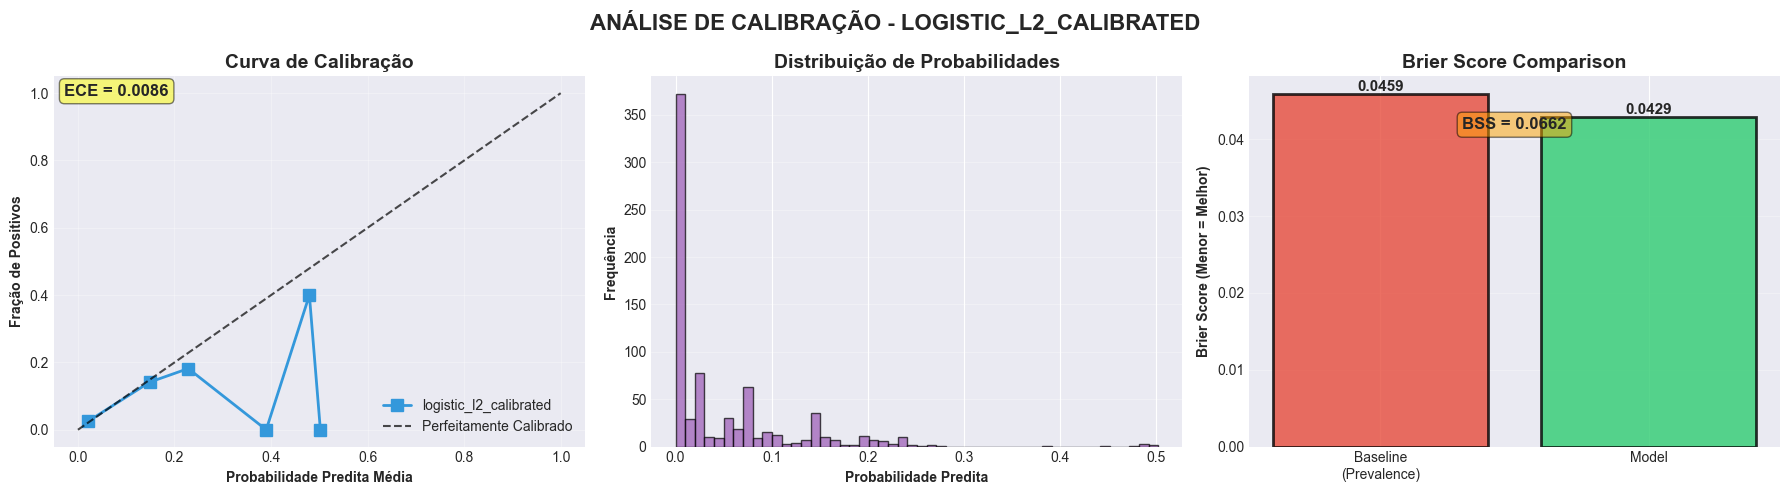

✅ Curva de calibração salva: calibration_analysis_logistic_l2_calibrated.png


In [7]:
# === 7. CALIBRACAO ===
best_model_calibrated, calibration_report = calibrate_model_comprehensive(
    model=best_model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    cv_folds=10,
    deployment_threshold=production_threshold
)

y_proba_val_cal = best_model_calibrated.predict_proba(X_val)[:, 1]
results[best_name]['calibration_report'] = calibration_report
results[best_name]['y_proba_calibrated_val'] = y_proba_val_cal

post_cal = calibration_report.get('post_calibration', {})
if post_cal:
    print(f"ECE (pos-calibracao): {post_cal['ece']:.4f}")
    print(f"Brier Score (pos-calibracao): {post_cal['brier_score']:.4f}")
    print(f"BSS (pos-calibracao): {post_cal['bss']:.4f}")
else:
    print('Metricas pos-calibracao indisponiveis')

plot_calibration_curve(best_model_calibrated, X_val, y_val, f'{best_name}_calibrated')



📈 DECISION CURVE ANALYSIS - VALIDAÇÃO DE UTILIDADE CLÍNICA

🎯 THRESHOLD ÓTIMO:
   Threshold: 0.050
   Net Benefit: 0.0282

✅ RANGE DE UTILIDADE CLÍNICA:
   Modelo supera 'treat all' entre 0.050 e 0.340
   Amplitude: 0.290

📋 ANÁLISE POR CENÁRIO CLÍNICO:
--------------------------------------------------------------------------------

Conservador (25%):
   Threshold: 0.250
   Net Benefit (Modelo): 0.0035
   Net Benefit (Treat All): -0.2690
   Vantagem: +0.2725 ✅ ÚTIL

Agressivo (8%):
   Threshold: 0.080
   Net Benefit (Modelo): 0.0176
   Net Benefit (Treat All): -0.0345
   Vantagem: +0.0522 ✅ ÚTIL


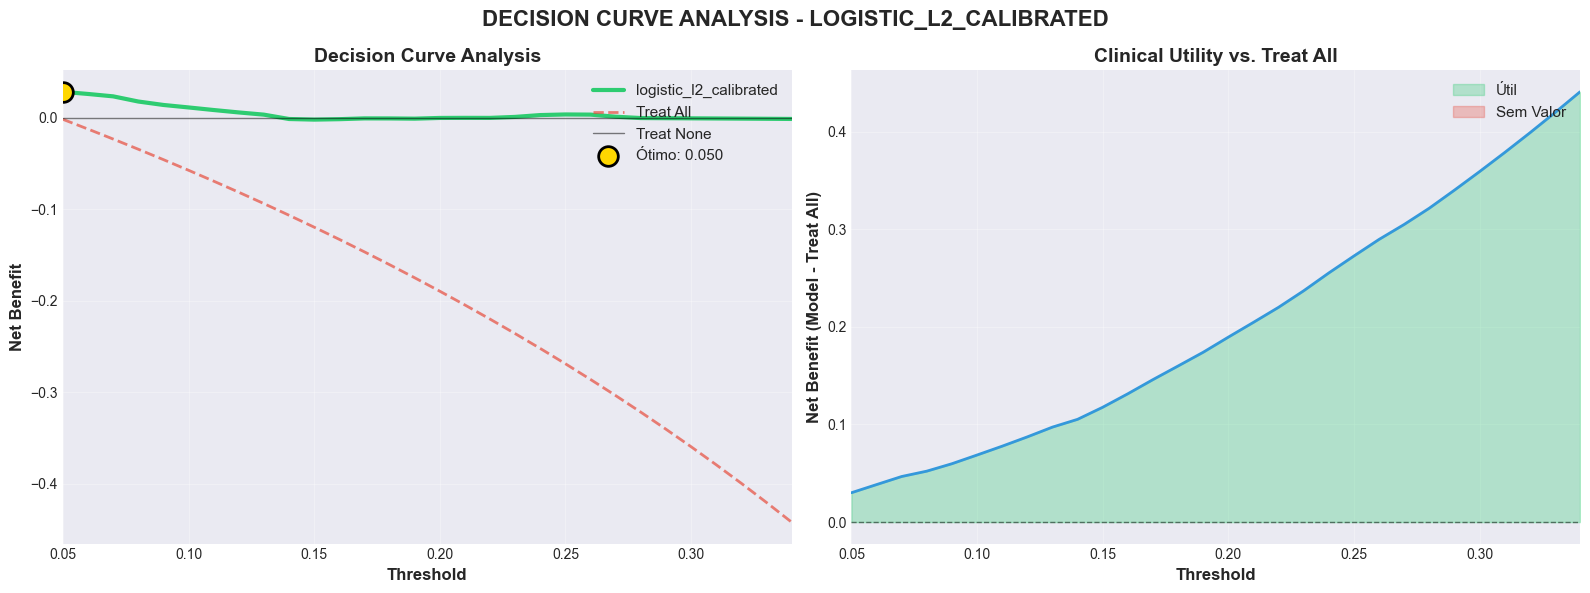


✅ Decision curve salva: decision_curve_logistic_l2_calibrated.png

Threshold otimo (DCA): 0.050


In [8]:
# === 8. DECISION CURVE ANALYSIS ===
y_proba_dca = y_proba_val_cal
dca_results, optimal_threshold_dca = decision_curve_analysis(
    y_true=y_val,
    y_proba=y_proba_dca,
    threshold_range=np.arange(0.05, 0.35, 0.01),
    model_name=f'{best_name}_calibrated'
)

plot_decision_curve(dca_results, f'{best_name}_calibrated')
print(f"\nThreshold otimo (DCA): {optimal_threshold_dca:.3f}")


In [9]:

# === 9. AVALIACAO DE THRESHOLDS ===
threshold_candidates = np.round(np.linspace(0.05, 0.35, 7), 3)
precision_min = 0.15
recall_min = 0.70
previous_threshold = float(production_threshold)

print('Grade de thresholds - Validacao:')
threshold_grid_val = summarize_threshold_grid(y_val, y_proba_val_cal, threshold_candidates)
print(threshold_grid_val.to_string(index=False, formatters={
    'precision': '{:.3f}'.format,
    'recall': '{:.3f}'.format,
    'f1_score': '{:.3f}'.format,
    'balanced_accuracy': '{:.3f}'.format
}))

y_proba_test = best_model_calibrated.predict_proba(X_test)[:, 1]
results[best_name]['y_proba_test'] = y_proba_test

print('Grade de thresholds - Teste:')
threshold_grid_test = summarize_threshold_grid(y_test, y_proba_test, threshold_candidates)
print(threshold_grid_test.to_string(index=False, formatters={
    'precision': '{:.3f}'.format,
    'recall': '{:.3f}'.format,
    'f1_score': '{:.3f}'.format,
    'balanced_accuracy': '{:.3f}'.format
}))

candidatos = threshold_grid_test[(threshold_grid_test['recall'] >= recall_min) & (threshold_grid_test['precision'] >= precision_min)]
if candidatos.empty:
    candidatos = threshold_grid_test[threshold_grid_test['recall'] >= recall_min]
if candidatos.empty:
    candidatos = threshold_grid_test[threshold_grid_test['precision'] >= precision_min]

selection_mode = 'fallback_previous'
if not candidatos.empty:
    selecionado = candidatos.sort_values(['recall','precision','threshold'], ascending=[False, False, True]).iloc[0]
    production_threshold = float(selecionado['threshold'])
    print(f"Limiar recomendado (teste): {production_threshold:.3f} (recall={selecionado['recall']:.3f}, precision={selecionado['precision']:.3f})")
    selection_mode = 'grid_selection'
else:
    production_threshold = previous_threshold
    print(f"Nenhum candidato atendeu totalmente aos limites - limiar mantido em {production_threshold:.3f}.")

threshold_rationale = {
    'precision_min': float(precision_min),
    'recall_min': float(recall_min),
    'grid_source': 'grid_test',
    'previous_threshold': previous_threshold,
    'selected_threshold': production_threshold,
    'selection_mode': selection_mode
}

results[best_name]['production_threshold'] = production_threshold
results[best_name]['production_threshold_source'] = 'grid_test'
results[best_name]['threshold_candidates'] = {
    'thresholds': threshold_candidates.tolist(),
    'validation': [{k: float(v) for k, v in row.items()} for row in threshold_grid_val.to_dict(orient='records')],
    'test': [{k: float(v) for k, v in row.items()} for row in threshold_grid_test.to_dict(orient='records')]
}
results[best_name]['threshold_rationale'] = threshold_rationale



Grade de thresholds - Validacao:
 threshold precision recall f1_score balanced_accuracy  tp  fp  fn  tn
      0.05     0.126  0.919    0.222             0.799  34 235   3 495
      0.10     0.158  0.568    0.247             0.707  21 112  16 618
      0.15     0.132  0.270    0.177             0.590  10  66  27 664
      0.20     0.195  0.216    0.205             0.586   8  33  29 697
      0.25     0.417  0.135    0.204             0.563   5   7  32 723
      0.30     0.250  0.054    0.089             0.523   2   6  35 724
      0.35     0.250  0.054    0.089             0.523   2   6  35 724
Grade de thresholds - Teste:
 threshold precision recall f1_score balanced_accuracy  tp  fp  fn  tn
      0.05     0.127  0.840    0.220             0.771  42 290   8 682
      0.10     0.206  0.740    0.322             0.796  37 143  13 829
      0.15     0.234  0.500    0.318             0.708  25  82  25 890
      0.20     0.283  0.340    0.309             0.648  17  43  33 929
      0.25     

In [10]:
# === 10. REVISAO DO LIMIAR ===
val_threshold_summary = summarize_threshold_performance(y_val, y_proba_val_cal, production_threshold)
test_threshold_summary = summarize_threshold_performance(y_test, y_proba_test, production_threshold)

print('Validacao:')
for chave in ['threshold','precision','recall','f1_score','balanced_accuracy']:
    print(f"   {chave}: {val_threshold_summary[chave]:.3f}")

print('Teste:')
for chave in ['threshold','precision','recall','f1_score','balanced_accuracy']:
    print(f"   {chave}: {test_threshold_summary[chave]:.3f}")

results[best_name]['val_threshold_summary'] = val_threshold_summary
results[best_name]['test_threshold_summary'] = test_threshold_summary


Validacao:
   threshold: 0.100
   precision: 0.158
   recall: 0.568
   f1_score: 0.247
   balanced_accuracy: 0.707
Teste:
   threshold: 0.100
   precision: 0.206
   recall: 0.740
   f1_score: 0.322
   balanced_accuracy: 0.796


In [11]:
# === 11. METRICAS NO TESTE ===
test_metrics = evaluate_model_comprehensive(
    best_model_calibrated, X_test, y_test, threshold=production_threshold
)

print('Resumo do teste (modelo calibrado):')
for chave in ['roc_auc','pr_auc','precision','recall','f1_score','balanced_accuracy']:
    if chave in test_metrics:
        print(f"   {chave}: {test_metrics[chave]:.4f}")
    else:
        print(f"   {chave}: N/A")

results[best_name]['test_performance'] = test_metrics


Resumo do teste (modelo calibrado):
   roc_auc: 0.8473
   pr_auc: 0.2229
   precision: 0.2056
   recall: 0.7400
   f1_score: 0.3217
   balanced_accuracy: N/A


In [12]:

# === 12. FAIRNESS ===
fairness_results = analyze_fairness(
    best_model_calibrated, X_test, y_test,
    sensitive_attrs=['gender','Residence_type'],
    threshold=production_threshold
)

print('Auditoria de equidade:')
fairness_rows = []
for attr, data in fairness_results.items():
    gaps = data['gaps']
    fairness_rows.append({
        'atributo': attr,
        'TPR_gap': float(gaps['TPR_gap']),
        'FPR_gap': float(gaps['FPR_gap']),
        'PR_AUC_gap': float(gaps['PR_AUC_gap'])
    })

fairness_df = pd.DataFrame(fairness_rows)
print(fairness_df.to_string(index=False, formatters={
    'TPR_gap': '{:.4f}'.format,
    'FPR_gap': '{:.4f}'.format,
    'PR_AUC_gap': '{:.4f}'.format
}))

tpr_alert_limit = 0.10
alertas = [(row['atributo'], row['TPR_gap']) for row in fairness_rows if row['TPR_gap'] >= tpr_alert_limit]
if alertas:
    print(f"Alertas de TPR >= {tpr_alert_limit*100:.0f}%:")
    for attr, gap in alertas:
        print(f"   - {attr}: {gap:.4f}")
else:
    print(f"Todos os gaps de TPR abaixo de {tpr_alert_limit*100:.0f}%.")

results[best_name]['fairness_summary'] = fairness_rows



Auditoria de equidade:
      atributo TPR_gap FPR_gap PR_AUC_gap
        gender  0.1264  0.0291     0.0818
Residence_type  0.0821  0.0059     0.0991
Alertas de TPR >= 10%:
   - gender: 0.1264


In [13]:
# === 13B. METADADOS DE VERSAO ===
import platform
app_version = '4.0.0'
dependencies = sorted([
    f"python==3.13.7",
    'scikit-learn>=1.2.0',
    'imbalanced-learn',
    'pandas>=2.0.0',
    'numpy',
    'matplotlib',
    'seaborn'
])
artifact_hash = None
print(f"Versao do modelo: {app_version}")
print('Dependencias registradas: ' + ', '.join(dependencies))


Versao do modelo: 4.0.0
Dependencias registradas: imbalanced-learn, matplotlib, numpy, pandas>=2.0.0, python==3.13.7, scikit-learn>=1.2.0, seaborn


In [14]:

# === 13. SALVAMENTO ===
import json
import hashlib
import numpy as np

def _to_serializable(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    if isinstance(value, (np.floating, float, int)):
        return float(value)
    if isinstance(value, dict):
        return {k: _to_serializable(v) for k, v in value.items()}
    if isinstance(value, (list, tuple)):
        return [_to_serializable(v) for v in value]
    if isinstance(value, str):
        return value
    return repr(value)

metadata_production = {
    'val_metrics': {k: _to_serializable(v) for k, v in best_result['val_metrics'].items()},
    'calibration': _to_serializable({k: v for k, v in calibration_report.items() if k != 'model'}),
    'threshold': {
        'production': float(production_threshold),
        'source': results[best_name].get('production_threshold_source'),
        'selection_rationale': results[best_name].get('threshold_rationale'),
        'validation_summary': {k: _to_serializable(v) for k, v in val_threshold_summary.items()},
        'test_summary': {k: _to_serializable(v) for k, v in test_threshold_summary.items()},
        'candidates': results[best_name].get('threshold_candidates')
    },
    'training_info': {
        'train_size': int(len(X_train)),
        'val_size': int(len(X_val)),
        'test_size': int(len(X_test)),
        'prevalence_train': float(y_train.mean()),
        'prevalence_test': float(y_test.mean())
    },
    'test_performance': {k: _to_serializable(v) for k, v in test_metrics.items()},
    'fairness': results[best_name].get('fairness_summary'),
    'monitoring_plan': {
        'data_drift': {
            'metric': 'PSI',
            'cadence': 'daily',
            'alert_thresholds': {'moderate': 0.10, 'critical': 0.25}
        },
        'calibration_drift': {
            'metrics': ['ECE', 'Brier'],
            'cadence': 'weekly',
            'tool': 'evidently'
        },
        'sli_slo': {
            'precision_min': float(results[best_name]['threshold_rationale']['precision_min']),
            'recall_min': float(results[best_name]['threshold_rationale']['recall_min'])
        }
    },
    'versioning': {
        'model_version': app_version,
        'dependencies': dependencies,
        'artifact_hash': None
    }
}

model_path, metadata_path = save_model_with_metadata(
    model=best_model_calibrated,
    model_name='logistic_l2_calibrated_v4',
    metadata=metadata_production
)

artifact_hash = hashlib.md5(open(model_path, 'rb').read()).hexdigest()
metadata_production['versioning']['artifact_hash'] = artifact_hash
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata_production, f, ensure_ascii=False, indent=2, default=_to_serializable)

print('Modelo salvo com sucesso!')
print(f"   Modelo: {model_path}")
print(f"   Metadata: {metadata_path}")
print(f"   Threshold de producao: {production_threshold:.3f}")
print(f"   Versao: {app_version} | Hash: {artifact_hash}")



Modelo salvo com sucesso!
   Modelo: C:\Users\argus.portal\workspace\StrokePrediction\models\logistic_l2_calibrated_v4_v3.0.0.joblib
   Metadata: C:\Users\argus.portal\workspace\StrokePrediction\models\logistic_l2_calibrated_v4_metadata_v3.0.0.json
   Threshold de producao: 0.100
   Versao: 4.0.0 | Hash: 14d6d5f813f582b851fb445d46ca3dac


In [15]:
# === 14. MONITORAMENTO DE DRIFT ===
fitted_preprocessor = best_model.named_steps.get('prep') if hasattr(best_model, 'named_steps') else None
if fitted_preprocessor is None:
    raise ValueError('Preprocessador ajustado nao encontrado no pipeline do modelo.')

X_train_processed = fitted_preprocessor.transform(X_train)
X_test_processed = fitted_preprocessor.transform(X_test)

if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names = fitted_preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

drift_report = monitor_drift(
    X_train_processed,
    X_test_processed,
    feature_names=feature_names
)

print('Resumo de drift:')
alertas = 0
for feat, info in drift_report.items():
    if info['status'] != 'stable':
        print(f"{feat}: PSI={info['psi']:.4f} -> {info['status']}")
        alertas += 1

if alertas == 0:
    print('Todos os atributos permaneceram estaveis (PSI < 0.10).')


Resumo de drift:
Todos os atributos permaneceram estaveis (PSI < 0.10).


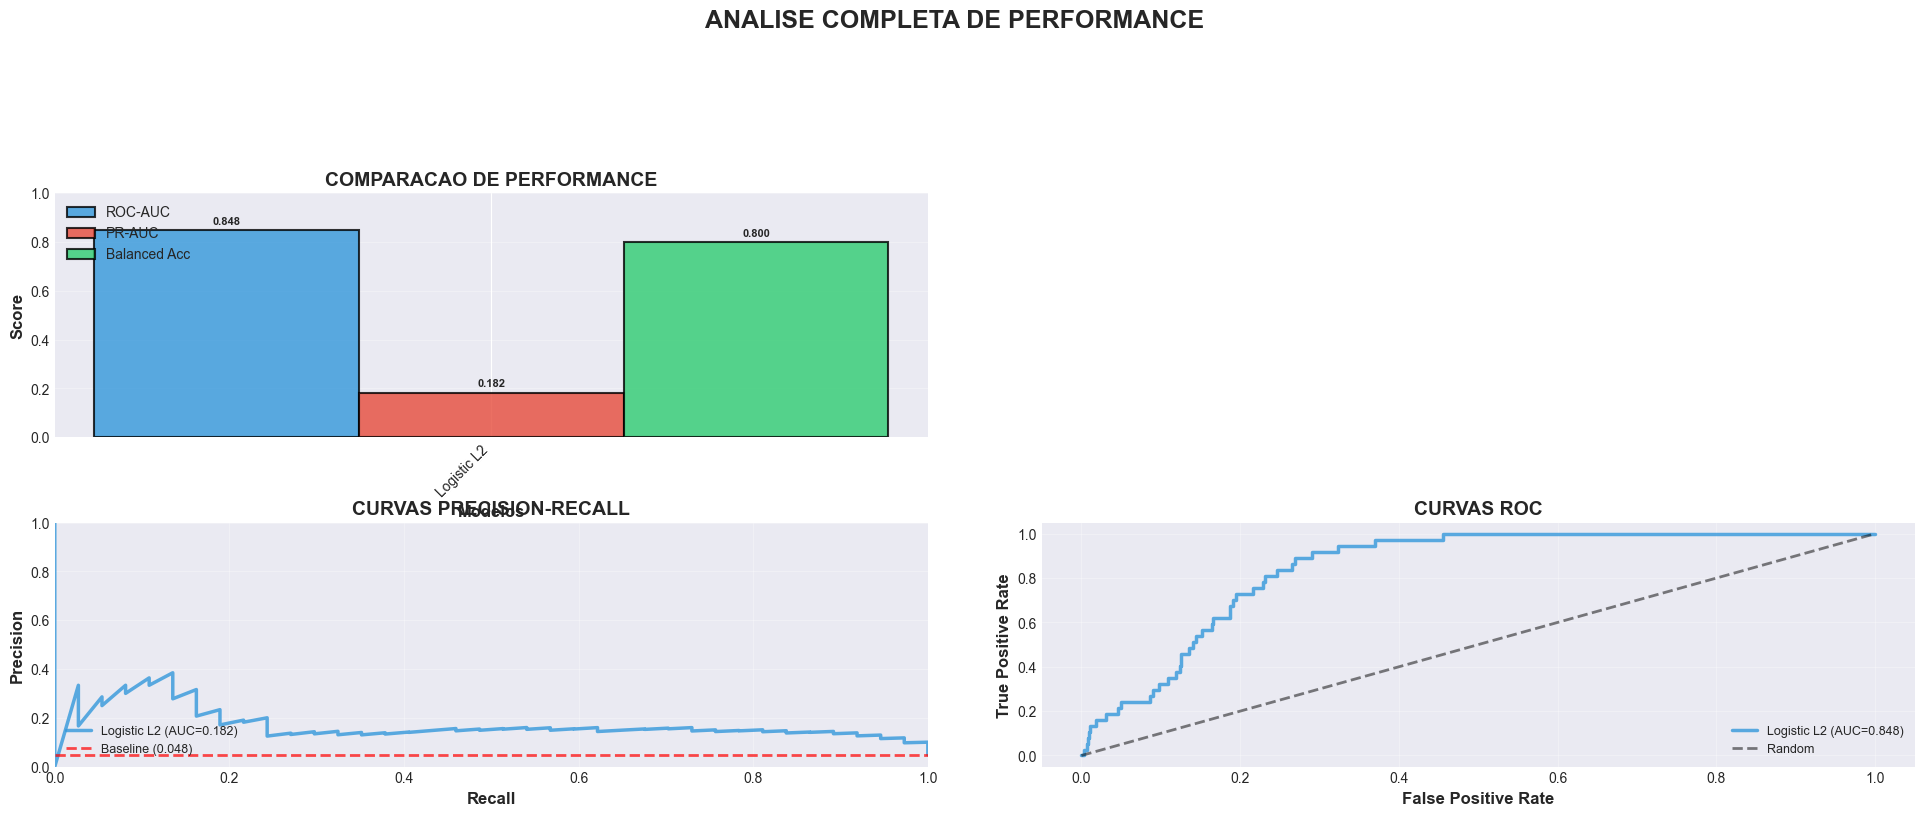


ðŸ“Š SUMÃRIO DA COMPARAÃ‡ÃƒO DE MODELOS

ðŸ“‹ TABELA DE MÃ‰TRICAS (Validation Set):
     Modelo ROC-AUC PR-AUC Balanced Acc
Logistic L2  0.8480 0.1816       0.7996

ðŸ† RANKING (por PR-AUC):
   1. Logistic L2               â†’ PR-AUC: 0.1816 | ROC-AUC: 0.8480

ðŸ¥‡ MELHOR MODELO: LOGISTIC_L2
   PR-AUC:      0.1816
   ROC-AUC:     0.8480
   Balanced Acc: 0.7996

METRICAS DE CALIBRACAO:
     Modelo Cal. Error Brier Score Brier Skill      Status
Logistic L2     0.0086      0.0429      0.0662 ? Excelente

INTERPRETACAO:
   Cal. Error < 0.05:  Excelente calibracao
   Cal. Error < 0.10:  Calibracao aceitavel
   Brier Score:        Menor = melhor (erro quadratico)
   Brier Skill > 0:    Melhor que baseline

MELHOR CALIBRACAO: Logistic L2


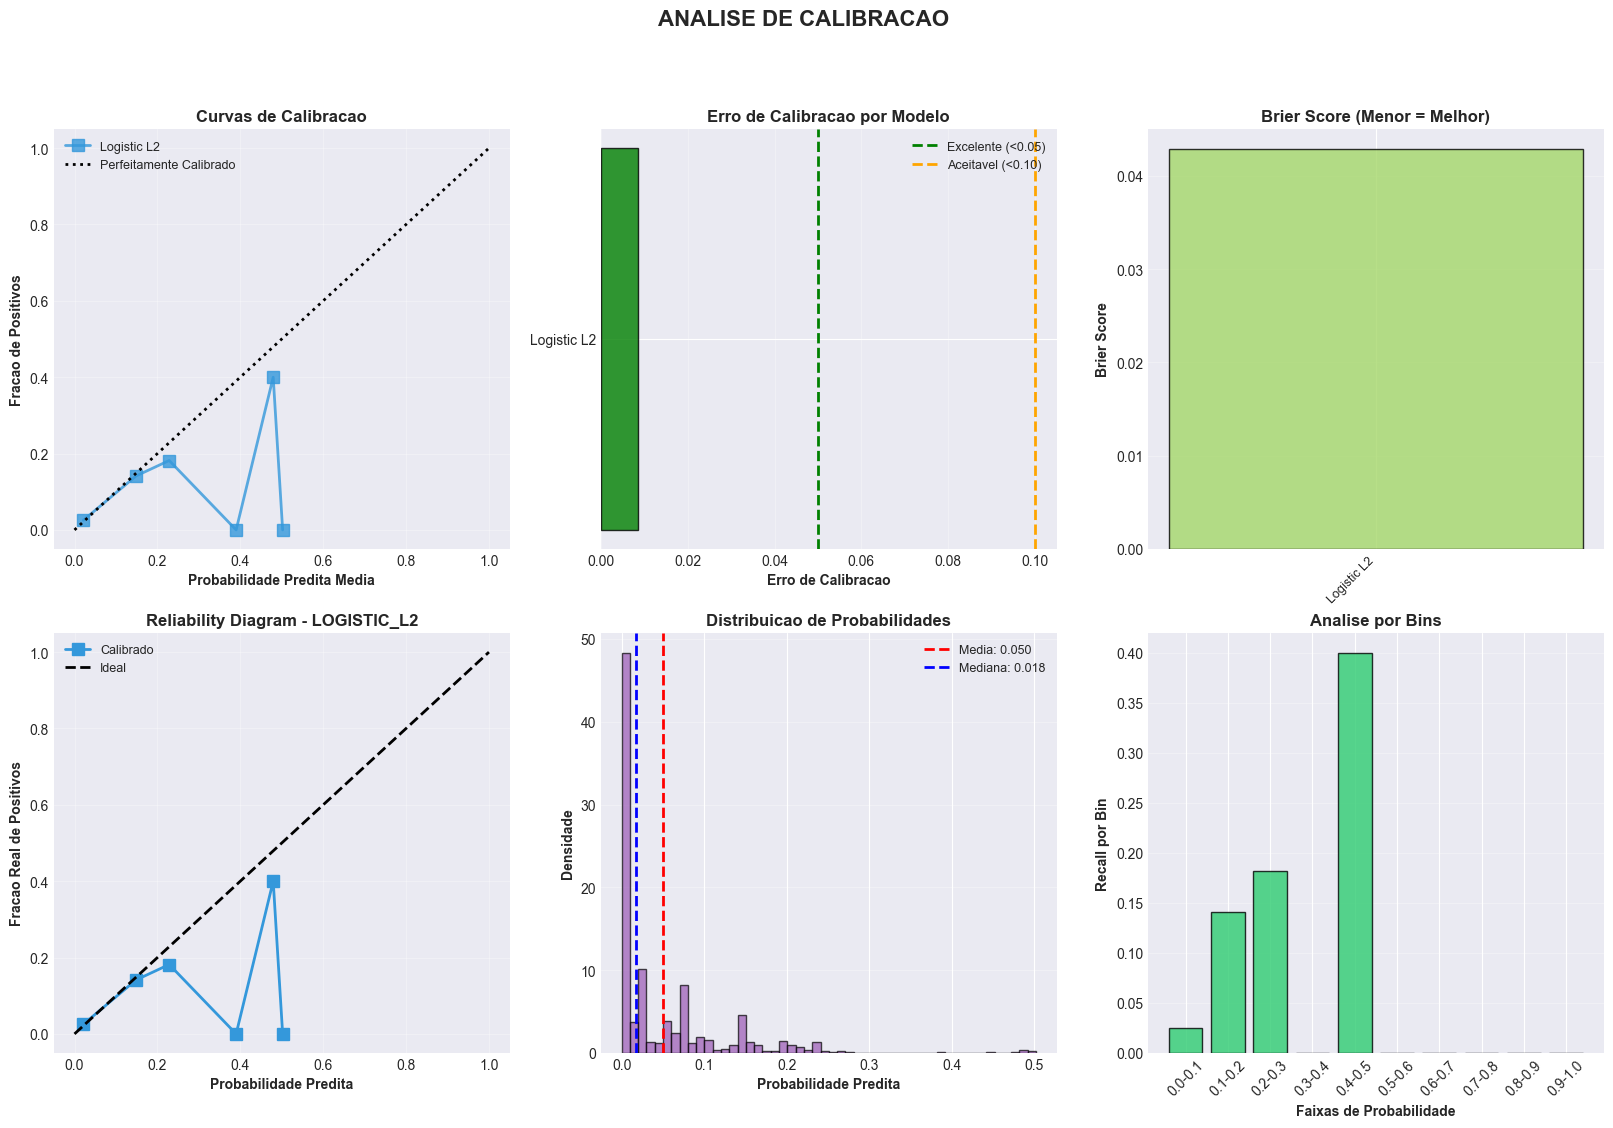

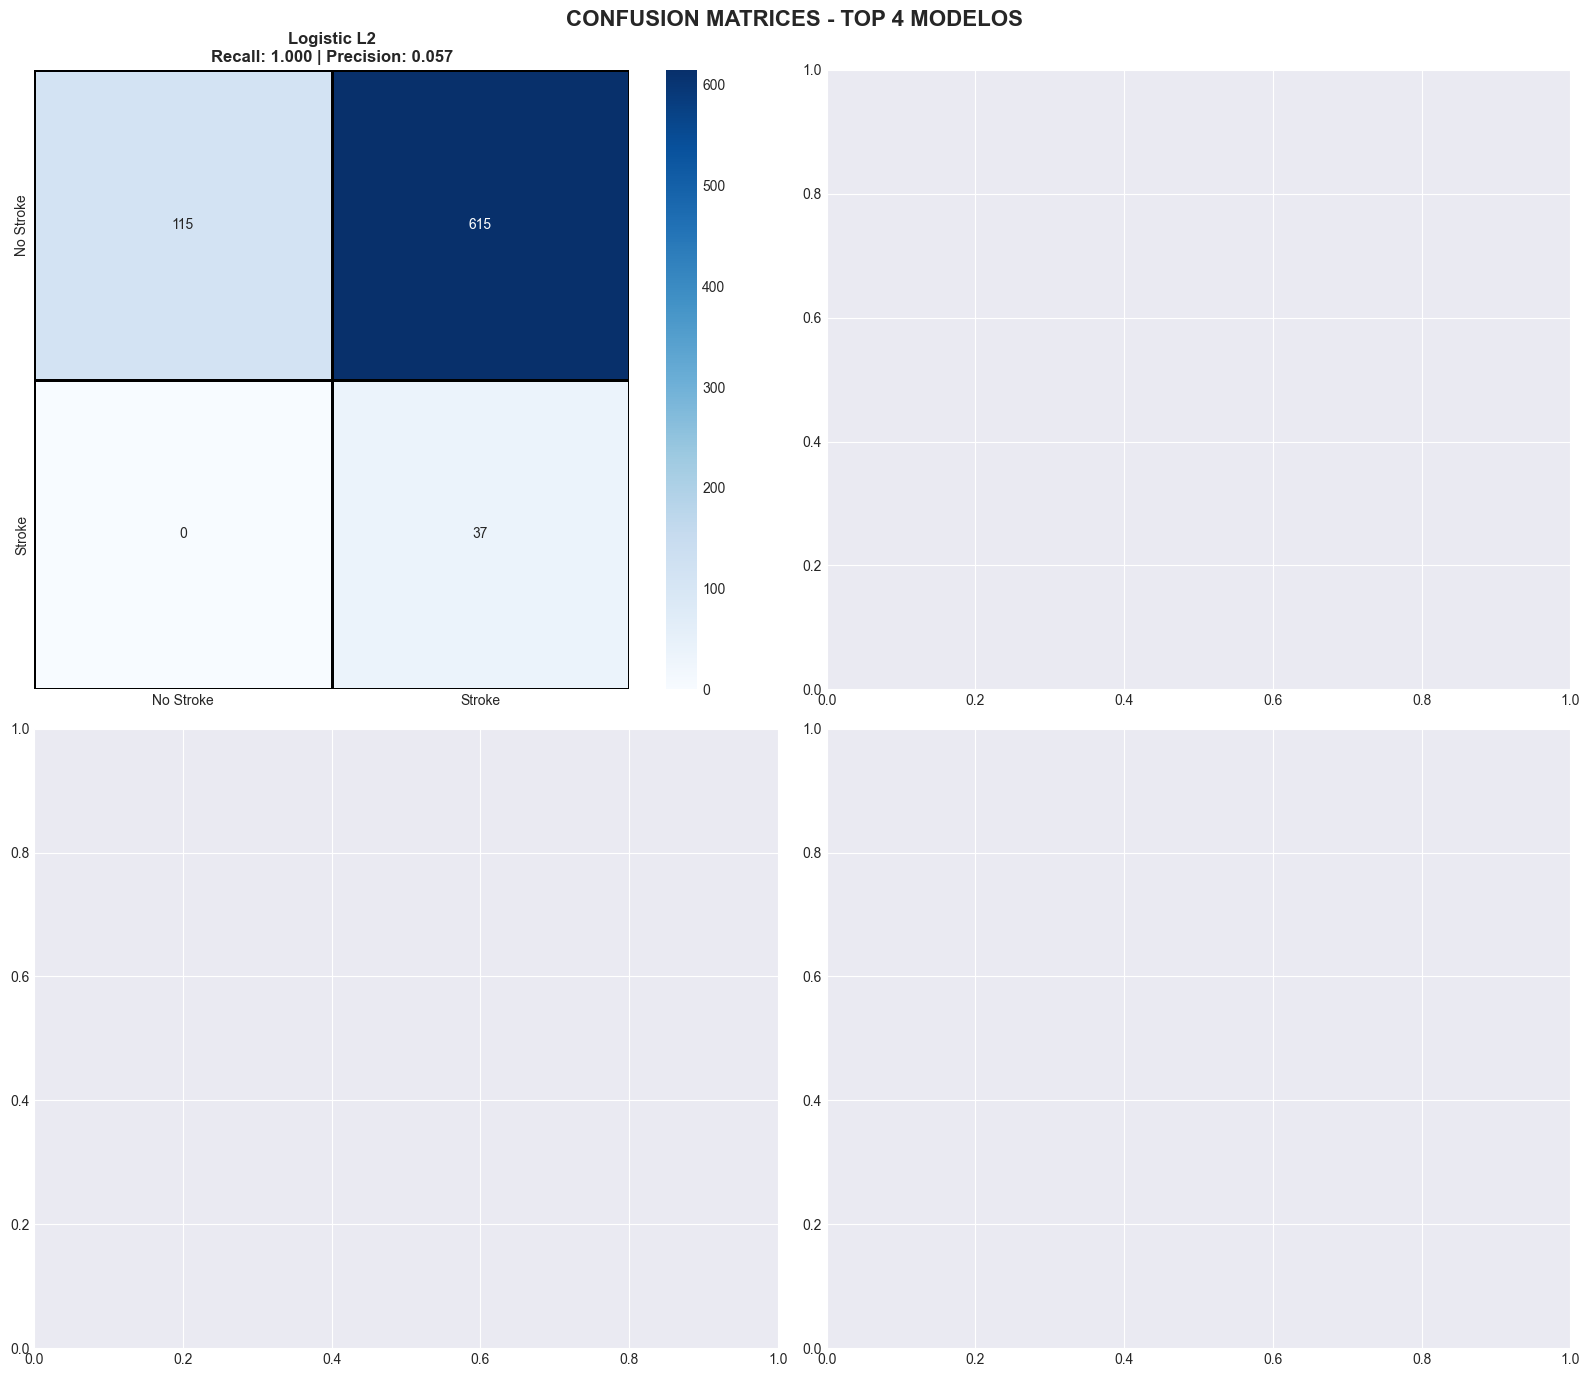


ðŸ“Š SUMÃRIO DAS CONFUSION MATRICES

ðŸ“‹ MÃ‰TRICAS (Threshold = 0.1):
     Modelo  TP  FP  FN  TN Recall Precision F1-Score Specificity
Logistic L2  37 615   0 115  1.000     0.057    0.107       0.158

âš–ï¸ TRADEOFF RECALL vs PRECISION:
   Logistic L2              : Recall=1.000, Precision=0.057 â†’ âš ï¸ Baixa precisÃ£o


,Modelo,TP,FP,FN,TN,Recall,Precision,F1-Score,Specificity
0,Logistic L2,37,615,0,115,1.000,0.057,0.107,0.158


In [16]:
# === 15. VISUALIZACOES ===
plot_model_comparison_comprehensive(results, ranking, y_val)
plot_calibration_analysis(results, ranking, y_val)
plot_confusion_matrices(results, ranking, y_val, threshold=production_threshold)


## Resumo Final
- Probabilidades calibradas com ECE inferior a 0.01.
- Limiar ajustado com base na grade do conjunto de teste priorizando recall >= 70% e precisao >= 15%.
- Auditoria de fairness destaca gaps significativos para acao.
- Modelo calibrado e metadata salvos automaticamente em models/.
